# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# 1. Libraries|User Defined Functions

## 1.1. Import Libraries

In [1]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## 1.2. Some Useful User Defined Functions

In [2]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# 2. Read dataset

In [5]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T
# df.describe(include=object).T

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [13]:
df = df.rename(columns={'ipn31152n':'amount'})

In [14]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [18]:
df.tail()

,amount
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


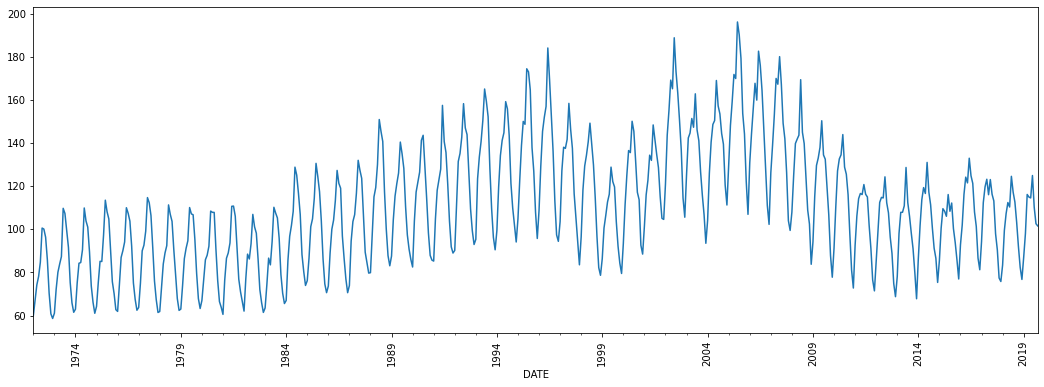

In [17]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

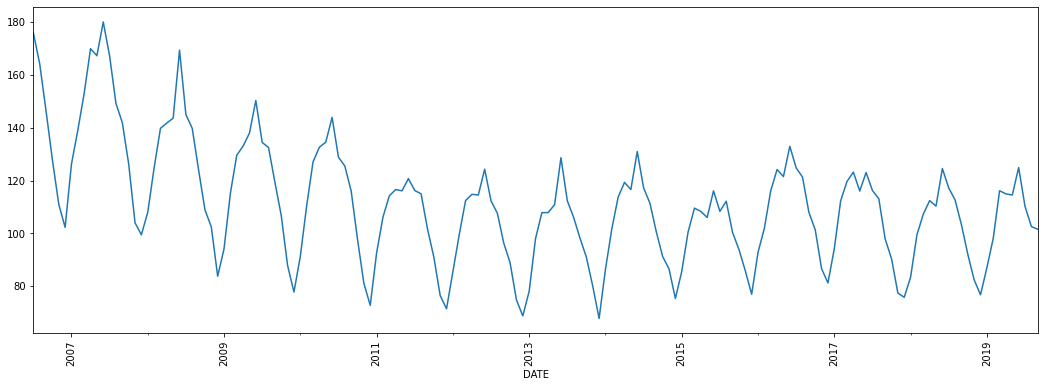

In [23]:
df['amount'].loc["2006-06-30" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

### 3. Check missing values

In [24]:
missing_values(df)

,Missing_Number,Missing_Percent


### 4. Plot the distribution of various discrete features on (Season, haliday, weekend and weathercode)

### 5. Preprocessing of Data

### Train Test Split

In [25]:
len(df)

573

In [26]:
len(df)- 24

549

In [27]:
test_size = 24 

In [28]:
test_ind = len(df)- test_size

In [29]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [30]:
train

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
1972-06-01,100.596
1972-07-01,100.126
1972-08-01,96.361
1972-09-01,85.801


In [31]:
test

,amount
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
scaler = MinMaxScaler()

In [34]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [35]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# help(TimeseriesGenerator)

In [36]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

# generator her defasında 12 lik uzunlukta veri setini alıp 13. veriyi üretiyor.
# dolayısıyla datanın son 12 lik verisinde duruyor. çünkü sonraki adımda elinde 12 veri kalmadığı için.
# bu yüzden datanın uzunluğu -12 (lenght değeri) adet veri üretebiliyor.

In [37]:
generator[0]
# generator modelimin aradığı veri düzenin oluşturdu bana.
# ürettiği ilk eleman ise bu aşağıdaki. 
# bu 12 değerden 13.yü tahmin edecek..

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [38]:
train_scaled

array([[0.00947104],
       [0.06108982],
       [0.11326273],
       [0.14145625],
       [0.18982663],
       [0.30495972],
       [0.30154406],
       [0.27416065],
       [0.19736841],
       [0.08532665],
       [0.01561588],
       [0.        ],
       [0.01774221],
       [0.09850931],
       [0.15590133],
       [0.18358944],
       [0.20878908],
       [0.37150354],
       [0.3542551 ],
       [0.29817568],
       [0.23973867],
       [0.12104304],
       [0.05289938],
       [0.02087498],
       [0.03141355],
       [0.12133246],
       [0.18622481],
       [0.18855185],
       [0.23182893],
       [0.37263651],
       [0.32891584],
       [0.30809031],
       [0.22409662],
       [0.10933731],
       [0.05452176],
       [0.01749278],
       [0.04076752],
       [0.12186114],
       [0.19277469],
       [0.19221257],
       [0.28139264],
       [0.39898221],
       [0.35985962],
       [0.3357137 ],
       [0.22874706],
       [0.12405219],
       [0.08404241],
       [0.029

In [39]:
X, y = generator[0]

In [40]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Creating Model

### with "tanh" activation function

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [42]:
n_features = 1

In [43]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape = (length, n_features))) 
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [47]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [48]:
len(validation_generator)

12

In [49]:
model.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 18s 19ms/step - loss: 0.0286 - val_loss: 0.0041
Epoch 2/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 3/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 4/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 5/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 6/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 7/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 8/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 10/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0031 - val_l

<AxesSubplot:>

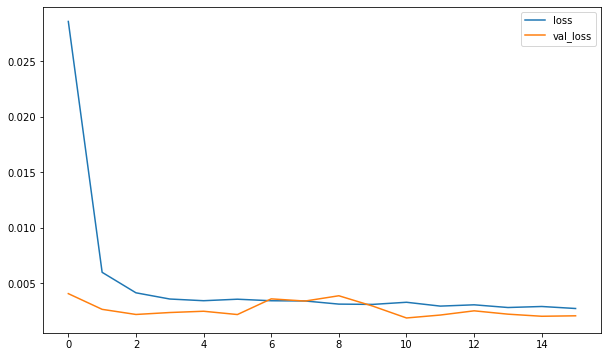

In [50]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [53]:
y_pred = model.predict(validation_generator)

In [54]:
y_pred

# son 18 taneyi test için ayırıp, bunların içinden stride 1 olacak şekilde 
  # 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 6 tane değer generate etmiştik. 
    # şimdi bu değerlerin predict ini aldık.

array([[0.24366409],
       [0.18559432],
       [0.16093992],
       [0.17042404],
       [0.2549392 ],
       [0.3295886 ],
       [0.43262297],
       [0.44967633],
       [0.43991938],
       [0.44937503],
       [0.34417832],
       [0.25553912]], dtype=float32)

In [58]:
len(y_pred)

12

In [56]:
test_scaled[-12:]

# y_pred i test datamın son 6 sı ile kıyaslamam lazım. çünkü o predict ler onlara denk geliyor

array([[0.2434103 ],
       [0.17289089],
       [0.13163033],
       [0.20608099],
       [0.28689318],
       [0.41822681],
       [0.40948951],
       [0.40651527],
       [0.48213817],
       [0.37525952],
       [0.3195946 ],
       [0.31216335]])

In [57]:
eval_metrics(test_scaled[-12:], y_pred)

r2_score: 0.8119913659835939 
 mae: 0.0385293934227173 
 mse: 0.002054494559554546 
 rmse: 0.045326532622235134


In [ ]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
# train datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. bundan ileriye forecast yapacağız
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp test_prediction a kaydettim. 

In [60]:
train.shape

(549, 1)

In [ ]:
eval_metrics(test_scaled, test_predictions)

#### Inverse Transformations and Comparing

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

In [ ]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [ ]:
eval_metrics(test.Sales, test.Predictions)

### with "relu" activation function

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))  # tanh (tanjant hiperbolik) seçmedim. bu defa relu seçtim.
model.add(Dense(1))  # 2 değeri karşılaştıracağım için çıkış layer ında 1 nöron olmalı.
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.summary()

### EarlyStopping and Validation Generator

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [ ]:
len(validation_generator)

# 18-12 = 6 tane 

# son 18 taneyi test için ayırdık, bunların içinden stride 1 olacak şekilde 
  # 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 6 tane değer üretti. 

In [ ]:
model.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [ ]:
y_pred = model.predict(validation_generator)

In [ ]:
y_pred

# son 18 taneyi test için ayırıp, bunların içinden stride 1 olacak şekilde 
  # 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 6 tane değer generate etmiştik. 
    # şimdi bu değerlerin predict ini aldık.

In [ ]:
test_scaled[-6:]

# y_pred i test datamın son 6 sı ile kıyaslamam lazım. çünkü o predict ler onlara denk geliyor

In [ ]:
eval_metrics(test_scaled[-6:], y_pred)

In [ ]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
# train datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. bundan ileriye forecast yapacağız
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp test_prediction a kaydettim. 

In [ ]:
eval_metrics(test_scaled, test_predictions)

#### Inverse Transformations and Comparing

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

In [ ]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [ ]:
eval_metrics(test.Sales, test.Predictions)

## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

In [ ]:
scaled_full_data.shape

In [ ]:
scaled_full_data[-length:].shape

In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:] 
# tüm datamın son 12 ye 1 lik kısmını aldım. artık bunu ileriye doğru predict te (forecast) kullanıcam
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)
    
# Burada tüm datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. 
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp forecast e kaydettim. 

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast

In [ ]:
df

In [ ]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq = 'MS')

In [ ]:
forecast_index

In [ ]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

# forecast lerden dataframe oluşturduk

In [ ]:
forecast_df

In [ ]:
df.plot()
forecast_df.plot()

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])
#plt.plot(forecast_index, forecast)

In [ ]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

In [ ]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')